# Data linkage



In [1]:
import pandas as pd
import numpy as np

# Visualization library
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Dates management
import datetime

# Table of content

# 1. Data Exploration

## 1.1 Data extracted from the Clinical Data Warehouse



In [2]:
# Patients
df_person = pd.read_pickle('data/df_person.pkl')

# Visits
df_visit = pd.read_pickle('data/df_visit.pkl')

# Diagnosis (condition)
df_condition = pd.read_pickle('data/df_condition.pkl')

## 1.2 Data provided by the deterministic deduplication algorithm


In [3]:
df_dedup_det = pd.read_pickle('data/df_dedup_deterministic.pkl')
df_dedup_det.info()
df_dedup_det.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 730 to 169
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unique_person_id  382 non-null    float64
 1   person_id         382 non-null    object 
dtypes: float64(1), object(1)
memory usage: 9.0+ KB


,unique_person_id,person_id
730,82045789.0,81164670
54,82895348.0,80219513
685,87636251.0,80569237
55,81605959.0,88999242
42,86475376.0,82757425


<br> The dataframe `df_dedup_det` is composed of 2 columns :
- *unique_person_id* : this id is the *real* id for the patient
- *person_id* : this id is another one, created by mistake

## 1.3 Data provided by the probabilistic deduplication algorithm

In [4]:
df_dedup_proba = pd.read_pickle('data/df_dedup_proba.pkl')
df_dedup_proba.info()
df_dedup_proba.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2896 entries, 33 to 38
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unique_person_id  2896 non-null   float64
 1   person_id         2896 non-null   object 
 2   prob              2896 non-null   float64
dtypes: float64(2), object(1)
memory usage: 90.5+ KB


,unique_person_id,person_id,prob
33,82840618.0,81126030,0.067232
29,83705392.0,83705392,0.062969
23,88145258.0,82890052,0.997885
161,86032115.0,86032115,0.082572
17,88272280.0,82950877,0.468085


# 2. Preprocessing

## 2.1 Deduplicating using the deterministic algorithm


In [5]:
# Outer Join
df_person_dedup_det = pd.merge(df_person, df_dedup_det, on = 'person_id', how = 'outer')

# Complete the unique_person_id column
df_person_dedup_det['unique_person_id'] = df_person_dedup_det['unique_person_id'].fillna(df_person_dedup_det['person_id'])

# Only keep one row per patient
df_person_dedup_det = df_person_dedup_det.drop_duplicates(['unique_person_id'], keep = 'first')

How many patients have we left ?

In [6]:
print(f"We have {df_person_dedup_det.unique_person_id.nunique()} unique patient ids in this dataset when using the determinist algorithm.")

We have 15786 unique patient ids in this dataset when using the determinist algorithm.


## 2.2 Deduplicatng using probabilistic algorithm

In [7]:
df_dedup_proba['prob'].describe()

count    2896.000000
mean        0.405208
std         0.383254
min         0.000137
25%         0.092972
50%         0.185377
75%         0.911526
max         1.000000
Name: prob, dtype: float64

Plot the estimated density of the distribution of the probabilities using `pandas.plot.density()`

[]

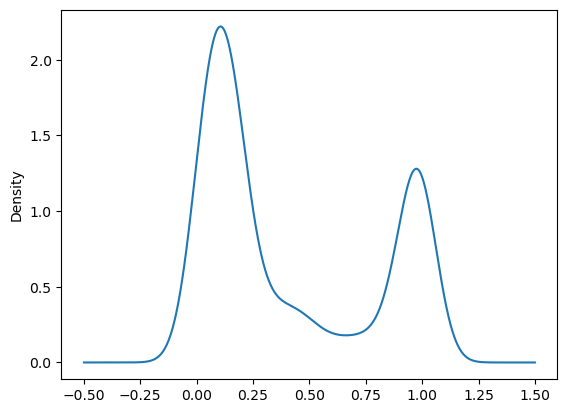

In [8]:
df_dedup_proba['prob'].plot.density()
plt.plot()

In [9]:
def deduplicate_proba(df_person: pd.DataFrame, df_dedup_proba: pd.DataFrame, score: int):
    #Only keep rows with a probability above the value score
    df_dedup_proba_score = df_dedup_proba[df_dedup_proba['prob'] > score]
    # Outer Join
    df_person_dedup_proba  = pd.merge(df_person, df_dedup_proba_score, on = 'person_id', how = 'outer')
    # Only unique ids in unique_person_id
    df_person_dedup_proba['unique_person_id'] = df_person_dedup_proba['unique_person_id'].fillna(df_person_dedup_proba['person_id'])
    # Only keep one row per patient
    df_person_dedup_proba = df_person_dedup_proba.drop_duplicates(['unique_person_id'], keep = 'first')
    return df_person_dedup_proba

In [10]:
df_person_dedup_proba_90 = deduplicate_proba(df_person, df_dedup_proba, score=0.90)
print(f"We have {df_person_dedup_proba_90.unique_person_id.nunique()} unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.90.")

We have 15406 unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.90.


In [11]:
df_person_dedup_proba_20 = deduplicate_proba(df_person, df_dedup_proba, score = 0.20)
print(f"We have {df_person_dedup_proba_20.unique_person_id.nunique()} unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.20.")

We have 15022 unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.20.


# 3. Statistical analysis

In [12]:
cancer_condition = {'C50','C500','C501','C502','C503','C504'}
risk_factors = {'Tabac':['Z587','Z720'], 'Alcool':['T51','K70','F10'], 'Diabete':['E10','E11','E12'], 'sub_psy':['Z864'], 'tum_herit':['Z803']}

from plot_hist import hist_risk_factors

## 3.1 Without deduplicating the person dataset

In [13]:
df_cancer = df_condition[df_condition['condition_source_value'].isin(cancer_condition)]
nbre_patients_cancer = df_cancer.person_id.nunique()
print(f'le nombre de patients atteints de cancer est : {nbre_patients_cancer}')

le nombre de patients atteints de cancer est : 4327


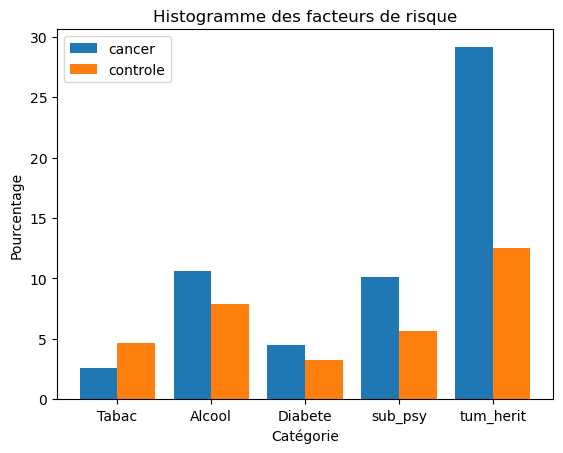

In [14]:
hist_risk_factors(risk_factors, df_cancer, df_person, df_condition, nbre_patients_cancer)

## 3.2 Using the determinist deduplication

In [15]:
df_condition_dedup_det = df_condition.merge(df_person_dedup_det[['person_id']], on='person_id', how='inner')
df_visit_dedup_det = df_visit.merge(df_person_dedup_det[['person_id']], on='person_id', how='left')

In [16]:
df_cancer_dedup_det = df_condition_dedup_det[df_condition_dedup_det['condition_source_value'].isin(cancer_condition)]
nbre_patients_cancer_dedup_det = df_cancer_dedup_det.person_id.nunique()
print(f'le nombre de patients atteints de cancer est : {nbre_patients_cancer}')

le nombre de patients atteints de cancer est : 4327


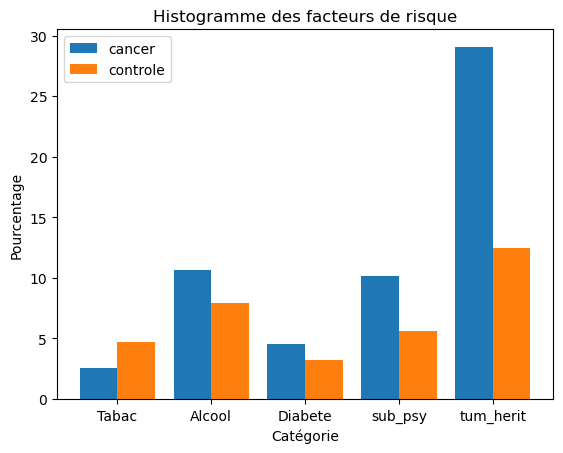

In [17]:
hist_risk_factors(risk_factors, df_cancer_dedup_det, df_person_dedup_det, df_condition_dedup_det, nbre_patients_cancer_dedup_det)

## 3.3 Using the probabilistic deduplication

### 3.3.1 score = 20

In [18]:
df_condition_dedup_proba_20 = df_condition.merge(df_person_dedup_proba_20[['person_id']], on='person_id', how='inner')
df_visit_dedup_proba_20 = df_visit.merge(df_person_dedup_proba_20[['person_id']], on='person_id', how='left')

In [19]:
df_cancer_dedup_proba_20 = df_condition_dedup_proba_20[df_condition_dedup_proba_20['condition_source_value'].isin(cancer_condition)]
nbre_patients_cancer_dedup_proba_20 = df_cancer_dedup_proba_20.person_id.nunique()
print(f'le nombre de patients atteints de cancer est : {nbre_patients_cancer}')

le nombre de patients atteints de cancer est : 4327


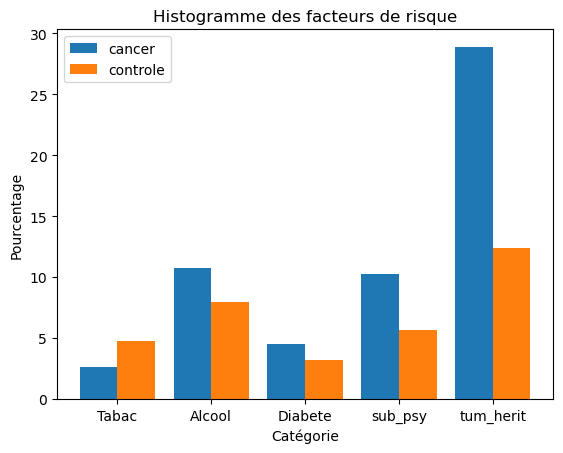

In [20]:
hist_risk_factors(risk_factors, df_cancer_dedup_proba_20, df_person_dedup_proba_20, df_condition_dedup_proba_20, nbre_patients_cancer_dedup_proba_20)

### 3.3.2 score = 90

In [21]:
df_condition_dedup_proba_90 = df_condition.merge(df_person_dedup_proba_90[['person_id']], on='person_id', how='inner')
df_visit_dedup_proba_90 = df_visit.merge(df_person_dedup_proba_90[['person_id']], on='person_id', how='left')

In [22]:
df_cancer_dedup_proba_90 = df_condition_dedup_proba_90[df_condition_dedup_proba_90['condition_source_value'].isin(cancer_condition)]
nbre_patients_cancer_dedup_proba_90 = df_cancer_dedup_proba_90.person_id.nunique()
print(f'le nombre de patients atteints de cancer est : {nbre_patients_cancer}')

le nombre de patients atteints de cancer est : 4327


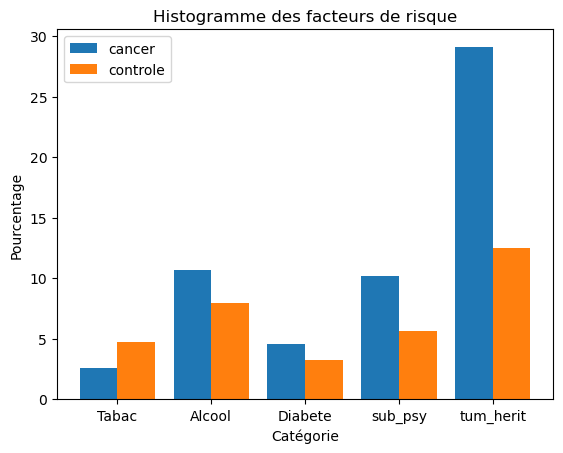

In [23]:
hist_risk_factors(risk_factors, df_cancer_dedup_proba_90, df_person_dedup_proba_90, df_condition_dedup_proba_90, nbre_patients_cancer_dedup_proba_90)

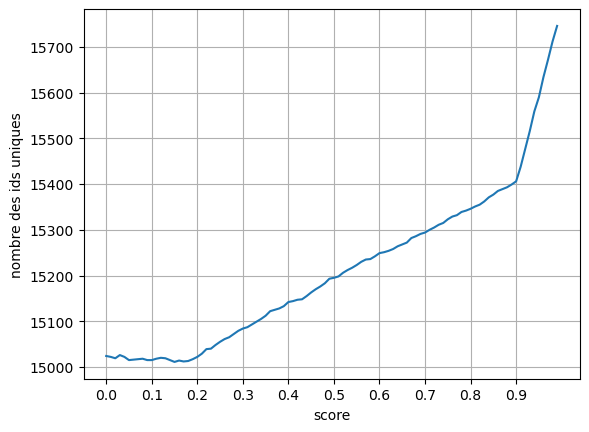

In [55]:
def nombre_id_uniques(p):
    df_person_dedup_proba_p = deduplicate_proba(df_person, df_dedup_proba, score=p)
    return df_person_dedup_proba_p.unique_person_id.nunique()
x,y=[],[]
for p in range (100):
    x.append(p/100)
    y.append(nombre_id_uniques(p/100))
    
plt.plot(x, y)
plt.xlabel('score')
plt.ylabel('nombre des ids uniques')
plt.grid(True)
plt.xticks(np.arange(0, 1, 0.1))  

plt.show()

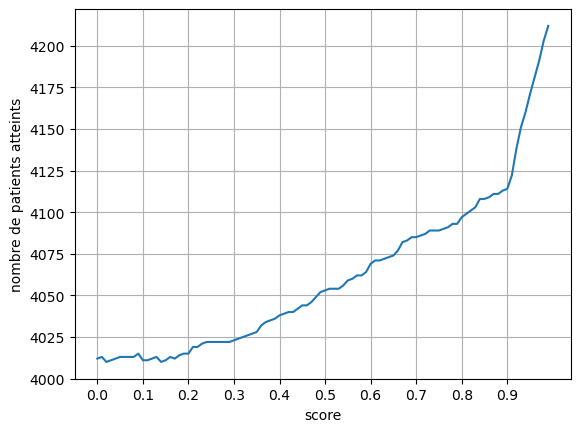

In [50]:
def nombre_patients_atteints(p):
    df_person_dedup_proba_p = deduplicate_proba(df_person, df_dedup_proba, score = p)
    df_condition_dedup_proba_p = df_condition.merge(df_person_dedup_proba_p[['person_id']], on='person_id', how='inner')
    df_visit_dedup_proba_p = df_visit.merge(df_person_dedup_proba_p[['person_id']], on='person_id', how='left')
    df_cancer_dedup_proba_p = df_condition_dedup_proba_p[df_condition_dedup_proba_p['condition_source_value'].isin(cancer_condition)]
    return df_cancer_dedup_proba_p.person_id.nunique()

x,y=[],[]
for p in range (100):
    x.append(p/100)
    y.append(nombre_patients_atteints(p/100))
    
plt.plot(x, y)
plt.xlabel('score')
plt.ylabel('nombre de patients atteints')
plt.grid(True)
plt.xticks(np.arange(0, 1, 0.1))  

plt.show()


